# To plot the periodogram of FRB20201130A

In [1]:
import os
from pathlib import Path

import pandas as pd
import numpy as np

from astropy.timeseries import LombScargle
from astropy.time import Time

DATAPATH = os.getenv('DATAPATH')
CATALOG_PATH = Path(DATAPATH, 'raw', 'catalog2023', 'catalog2023_profile.parquet')
CATALOG_PATH_CSV = Path(DATAPATH, 'raw', 'catalog2023', 'chimefrb2023repeaters.csv')
CATALOG1_PATH_PARQUET = Path(DATAPATH, 'catalog_1.parquet')

cat1 = pd.read_parquet(CATALOG1_PATH_PARQUET)[["eventname","repeater_name", "mjd_400"]]
cat1['catalog'] = 'Catalog 1'
cat2023 = pd.read_csv(CATALOG_PATH_CSV)[["tns_name","repeater_name","mjd_400"]].rename(columns={'tns_name':'eventname'})
cat2023['catalog'] = 'Catalog 2023'
data = pd.concat([cat1, cat2023])
data['mjd'] = data['mjd_400']
data

,eventname,repeater_name,mjd_400,catalog,mjd
0,FRB20180725A,-9999,58324.749803,Catalog 1,58324.749803
1,FRB20180727A,-9999,58326.036262,Catalog 1,58326.036262
2,FRB20180729A,-9999,58328.033565,Catalog 1,58328.033565
3,FRB20180729B,-9999,58328.728032,Catalog 1,58328.728032
4,FRB20180730A,-9999,58329.151134,Catalog 1,58329.151134
...,...,...,...,...,...
146,FRB20210313E,FRB20201221B,59286.202113,Catalog 2023,59286.202113
147,FRB20210331F,FRB20210323C,59304.147737,Catalog 2023,59304.147737
148,FRB20210331F,FRB20210323C,59304.147737,Catalog 2023,59304.147737
149,FRB20210426B,FRB20210323C,59330.091835,Catalog 2023,59330.091835


In [2]:
# chosen_name = 'FRB20201130A' # (13)
# chosen_name = 'FRB20180916B' # (77)
chosen_name = 'FRB20190915D' # 👍 (10)
# chosen_name = 'FRB20200929C' # (10)
chosen_name = 'FRB20190804E' # 👍 (10) ? 
chosen_name = 'FRB20191106C' # 👍 (7)
# chosen_name = 'FRB20201221B'
selected = data[['repeater_name', 'mjd', 'catalog']].sort_values(by='mjd')
selected[chosen_name] = (selected['repeater_name'] == chosen_name).astype(int)

In [3]:
kwargs = dict(
    minimum_frequency=0,
    maximum_frequency=1,
    samples_per_peak=1_000
)

LS = LombScargle(selected['mjd'].to_numpy(), selected[chosen_name].to_numpy())
freq, power = LS.autopower(**kwargs)

LS_Window = LombScargle(selected['mjd'].to_numpy(), 1)
freq_window, power_window = LS_Window.autopower(**kwargs)

false_alarm_level = LS.false_alarm_level(0.01)

periodogram = pd.DataFrame({'period': 1/freq, 'power': power, 'freq': freq, 'power_window': power_window})

d:\home\kerja\sarjana\.venv\lib\site-packages\astropy\timeseries\periodograms\lombscargle\implementations\fast_impl.py:102: RuntimeWarning: invalid value encountered in divide
  tan_2omega_tau = (S2 - 2 * S * C) / (C2 - (C * C - S * S))
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13456\3601994225.py:15: RuntimeWarning: divide by zero encountered in divide
  periodogram = pd.DataFrame({'period': 1/freq, 'power': power, 'freq': freq, 'power_window': power_window})


In [4]:
# Estimate error using leave one out resampling *jackknife

detections = selected.loc[selected[chosen_name] == 1].index

kwargs = dict(
    minimum_frequency=0,
    maximum_frequency=1,
    samples_per_peak=100
)

# include all-included sample's frequency
best_freqs = [freq[np.nanargmax(power)]]
for idx in detections:
    reduced = selected.loc[selected.index != idx]
    LS = LombScargle(reduced['mjd'].to_numpy(), reduced[chosen_name].to_numpy())
    freq, power = LS.autopower(**kwargs)
    best_freqs.append(freq[np.nanargmax(power)])

stats = pd.DataFrame(1/np.array(best_freqs)).describe()

d:\home\kerja\sarjana\.venv\lib\site-packages\astropy\timeseries\periodograms\lombscargle\implementations\fast_impl.py:131: RuntimeWarning: invalid value encountered in divide
  power = YC * YC / CC + YS * YS / SS
d:\home\kerja\sarjana\.venv\lib\site-packages\astropy\timeseries\periodograms\lombscargle\implementations\fast_impl.py:102: RuntimeWarning: invalid value encountered in divide
  tan_2omega_tau = (S2 - 2 * S * C) / (C2 - (C * C - S * S))


In [6]:
mean = stats.loc['mean'].item()
low = mean - 1.5*stats.loc['std'].item()
high = mean + 1.5*stats.loc['std'].item()
1/freq[np.argmax(power)], mean, low, high

(1098.779119227022, 891.3127236447014, 1306.2455148093427)

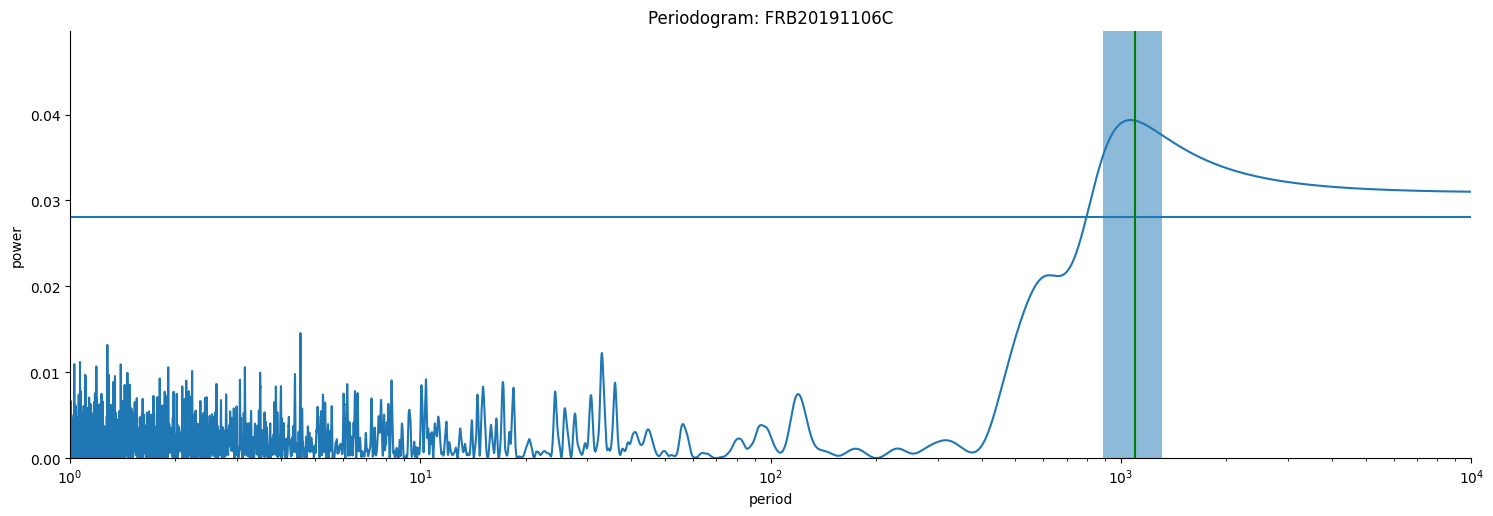

In [7]:
import seaborn as sns

xaxis = 'period'

G = sns.relplot(periodogram,x=xaxis, y='power', aspect=3, kind='line')
# sns.lineplot(periodogram, x=xaxis, y='power_window', color='orange', alpha=0.5, ax=G.ax)
G.ax.axhline(false_alarm_level)
# G.ax.axvline(1/freq[np.nanargmax(power)], color='red')
G.ax.axvline(mean, color='green')
G.ax.axvspan(low, high, alpha=0.5)
_=G.ax.set(ylim=(0,np.nanmax(power)*1.2),xlim=(1,10_000), xscale='log', title=f'Periodogram: {chosen_name}')

In [8]:
1/freq[np.nanargmax(power)], mean, low, high

(939.5719932837366, 1098.779119227022, 891.3127236447014, 1306.2455148093427)

[Text(0.5, 1.0, 'Count distribution: FRB20191106C'), (0.0, 1.0)]

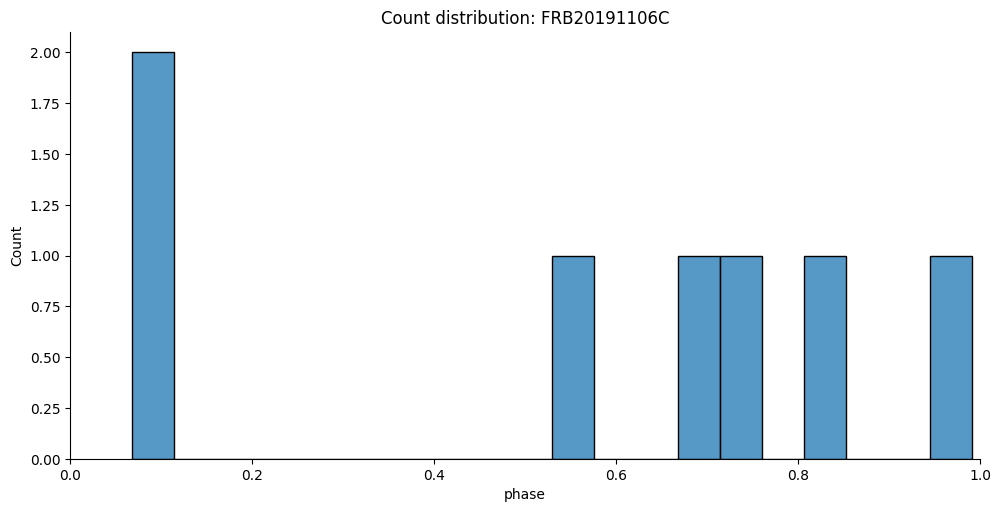

In [18]:
period = 1/freq[np.nanargmax(power)]
# period = mean
selected['phase'] = (selected['mjd'] / period) % 1
g = sns.displot(selected.loc[selected[chosen_name] == 1], x='phase', aspect=2, bins=20)
# sns.kdeplot(selected.loc[selected[chosen_name] == 1], x='phase')
g.ax.set(title=f'Count distribution: {chosen_name}', xlim=(0,1))